# AmExpert 2019 Machine Learning Hackathon

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.

# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/amex-2019/val_fold_0_h2o transform.csv
/kaggle/input/amex-2019/LGBM_oof_withtrans.npy
/kaggle/input/amex-2019/test_preds_h2o.csv
/kaggle/input/amex-2019/test_preds_4.csv
/kaggle/input/amex-2019/val_fold_4_h2o transform.csv
/kaggle/input/amex-2019/campaign_data.csv
/kaggle/input/amex-2019/test_preds_0 GPU.csv
/kaggle/input/amex-2019/item_data.csv
/kaggle/input/amex-2019/train_fold_0_h2o transform.csv
/kaggle/input/amex-2019/train_0_full_enc_trx.csv
/kaggle/input/amex-2019/submission_withtrans.csv
/kaggle/input/amex-2019/test_fold_4_h2o transform.csv
/kaggle/input/amex-2019/val_0_full_enc_trx.csv
/kaggle/input/amex-2019/customer_transaction_data.csv
/kaggle/input/amex-2019/valid_preds_1.csv
/kaggle/input/amex-2019/LGBM_oof_tfidf.npy
/kaggle/input/amex-2019/val_fold_1_h2o transform.csv
/kaggle/input/amex-2019/train_fold_3_h2o transform.csv
/kaggle/input/amex-2019/test_fold_2_h2o transform.csv
/kaggle/input/amex-2019/test_0_full_enc_trx.csv
/kaggle/input/amex-2019/val_0_trx.c

In [2]:
pd.options.display.max_columns =200
pd.options.display.max_rows = 500

# Read all input files

In [3]:
Path ='../input/amex-2019/'
train = pd.read_csv(Path+'train.csv')
print('train.shape:',train.shape)
campaign_data = pd.read_csv(Path+'campaign_data.csv')
print('campaign_data.shape:',campaign_data.shape)
coupon_item_mapping = pd.read_csv(Path+'coupon_item_mapping.csv')
print('coupon_item_mapping.shape:',coupon_item_mapping.shape)
customer_demographics = pd.read_csv(Path+'customer_demographics.csv')
print('customer_demographics.shape:',customer_demographics.shape)
item_data = pd.read_csv(Path+'item_data.csv')
print('item_data.shape:',item_data.shape)
subm = pd.read_csv(Path+'sample_submission.csv')
print('subm.shape:',subm.shape)
test = pd.read_csv(Path+'test.csv')
print('test.shape:',test.shape)             

train.shape: (78369, 5)
campaign_data.shape: (28, 4)
coupon_item_mapping.shape: (92663, 2)
customer_demographics.shape: (760, 7)
item_data.shape: (74066, 4)
subm.shape: (50226, 2)
test.shape: (50226, 4)


In [4]:
customer_transaction_data = pd.read_csv(Path+'customer_transaction_data.csv')
print('customer_transaction_data.shape:',customer_transaction_data.shape)

customer_transaction_data.shape: (1324566, 7)


## Drop  duplicate rows  in  train table 
## Drop id columns from train and test

In [5]:
#drop id column and duplicates
print(train.shape)
train = train.drop('id',axis=1).drop_duplicates()
print('train shape after dropping duplicates:',train.shape)
#drop id column from test
test = test.drop('id',axis=1)

(78369, 5)
train shape after dropping duplicates: (78357, 4)


## Drop  duplicate rows  in  customer_transaction_data table 

In [6]:
#remove duplicates from customer trans
print(customer_transaction_data.shape)
customer_transaction_data = customer_transaction_data.drop_duplicates()
print(customer_transaction_data.shape)
customer_transaction_data.head()

(1324566, 7)
(1321650, 7)


,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0


## Set target as "redemption_status" column

In [7]:
targetcol='redemption_status'
target = train[targetcol]

## Data Explorations

In [8]:
campaign_data.head()

,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13


## Get the list of train campaigns and test campaigns

In [9]:
test_campaign  = test['campaign_id'].unique()
train_campaign  = train['campaign_id'].unique()

print(campaign_data[campaign_data['campaign_id'].isin(train_campaign)])
print(campaign_data[campaign_data['campaign_id'].isin(test_campaign)])

    campaign_id campaign_type start_date  end_date
10           13             X   19/05/13  05/07/13
11           11             Y   22/04/13  07/06/13
12           12             Y   22/04/13  24/05/13
13           10             Y   08/04/13  10/05/13
14            9             Y   11/03/13  12/04/13
15            8             X   16/02/13  05/04/13
16            7             Y   02/02/13  08/03/13
17            6             Y   28/01/13  01/03/13
18            3             Y   22/12/12  16/02/13
19            5             Y   12/01/13  15/02/13
20            4             Y   07/01/13  08/02/13
21            1             Y   12/12/12  18/01/13
22            2             Y   17/12/12  18/01/13
23           30             X   19/11/12  04/01/13
24           29             Y   08/10/12  30/11/12
25           28             Y   16/09/12  16/11/12
26           27             Y   25/08/12  27/10/12
27           26             X   12/08/12  21/09/12
   campaign_id campaign_type st

In [10]:
print(item_data.shape)
item_data.head()

(74066, 4)


,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


## Check data types and missing values by using pandas info method


In [11]:
print(train.info())
print(campaign_data.info())
print(coupon_item_mapping.info())
print(customer_demographics.info())
print(item_data.info())
print(customer_transaction_data.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78357 entries, 0 to 78368
Data columns (total 4 columns):
campaign_id          78357 non-null int64
coupon_id            78357 non-null int64
customer_id          78357 non-null int64
redemption_status    78357 non-null int64
dtypes: int64(4)
memory usage: 3.0 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
campaign_id      28 non-null int64
campaign_type    28 non-null object
start_date       28 non-null object
end_date         28 non-null object
dtypes: int64(1), object(3)
memory usage: 1.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92663 entries, 0 to 92662
Data columns (total 2 columns):
coupon_id    92663 non-null int64
item_id      92663 non-null int64
dtypes: int64(2)
memory usage: 1.4 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
customer_id       760 non-null int64
age_range         760

In [12]:
print('uniques')
print('age_range:',customer_demographics['age_range'].nunique())
print('marital_status:',customer_demographics['marital_status'].nunique())
print('family_size:',customer_demographics['family_size'].nunique())
print('no_of_children:',customer_demographics['no_of_children'].nunique())

print()
print('brand:',item_data['brand'].nunique())
print('item_id:',item_data['item_id'].nunique())
print('category:',item_data['category'].nunique())
print('brand_type:',item_data['brand_type'].nunique())

uniques
age_range: 6
marital_status: 2
family_size: 5
no_of_children: 3

brand: 5528
item_id: 74066
category: 19
brand_type: 2


- It could be seen from above that only `customer_demographics` has missing values and all other tables have complete data.

- Also, some of the column datatypes are 'object' and from these, the categorical columns are determined as follows. Though `brand` and `item_id`from `item_data` table are not listed as object types, these are categorical from its meaning. 

| Tables|  Categorical columns
|----------------------|-------------------------------|
|customer_demographics        |age_range, marital_status, family_size, no_of_children
|item_data       |brand_type, category, brand, item_id |


> **Note**: The columns `brand` and `item_id` from `item_data` have unique values of around 5000+ and 74000+ respectively and hence these categorical fields need to be treated differently from the rest of the categorical columns

## View top elements of each table

In [13]:
train.head()

,campaign_id,coupon_id,customer_id,redemption_status
0,13,27,1053,0
1,13,116,48,0
2,9,635,205,0
3,13,644,1050,0
4,8,1017,1489,0


In [14]:
test.head()

,campaign_id,coupon_id,customer_id
0,22,869,967
1,20,389,1566
2,22,981,510
3,25,1069,361
4,17,498,811


In [15]:
campaign_data.head()

,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13


In [16]:
coupon_item_mapping.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


In [17]:
customer_demographics.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [18]:
print(customer_transaction_data.shape)
customer_transaction_data.head()

(1321650, 7)


,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0


In [19]:
print(customer_transaction_data.groupby(['date','customer_id','item_id']).size().shape)

(1320387,)


In [20]:
print(coupon_item_mapping['item_id'].nunique())
customer_transaction_data['item_id'].nunique()

36289


74063

In [21]:
print(campaign_data['campaign_id'].unique())
print(train['campaign_id'].unique())
print(test['campaign_id'].unique())

[24 25 20 23 21 22 18 19 17 16 13 11 12 10  9  8  7  6  3  5  4  1  2 30
 29 28 27 26]
[13  9  8 11 29 30  2  5 12 26  3  4 10  7 28 27  6  1]
[22 20 25 17 18 21 23 19 16 24]


## Check the proportion of target class in train

In [22]:
train['redemption_status'].value_counts()

0    77640
1      717
Name: redemption_status, dtype: int64

It could be seen from above that target class of 1 has presence of less than 1%. Hence there is also **class imbalance** problem in the dataset.

## Data Preprocessing

In [23]:
def labelencoding(data,enccols):
    for col in enccols:
        data[col],indexer = pd.factorize(data[col], sort=True )
        print('col:{0} indexer:{1}'.format(col,indexer))
        data.loc[data[col]==-1,col]=np.nan
    return data

def gendate_feats(data,datecols,format='mm/dd/yy'):
    for col in datecols:
        data[col] = pd.to_datetime(data[col],format=format)
        data[col+'_day'] = data[col].dt.day
        data[col+'_month'] = data[col].dt.month
        data[col+'_year'] = data[col].dt.year
        data[col+'_dayofweek'] = data[col].dt.dayofweek
        data[col+'_isweekend'] = (data[col+'_dayofweek']>=5).astype('int')
        data[col+'_week'] = data[col].dt.week
        
    return data

### Label Encoding

Label encoding is performed on below categorical data.
 - _brand_type_ and _category_ columns in `item_data` table 
 - _marital_status_, _age_range_, _family_size_,   _no_of_children_ in `customer_demographics` table 
 - _campaign_type_ in `campaign_data` table

In [24]:
#Label Encoding 
item_data = labelencoding(item_data,['brand_type', 'category'])
customer_demographics = labelencoding(customer_demographics,['marital_status', 'age_range',
                                                            'family_size', 'no_of_children'])
campaign_data = labelencoding(campaign_data,['campaign_type'])

col:brand_type indexer:Index(['Established', 'Local'], dtype='object')
col:category indexer:Index(['Alcohol', 'Bakery', 'Dairy, Juices & Snacks', 'Flowers & Plants',
       'Fuel', 'Garden', 'Grocery', 'Meat', 'Miscellaneous',
       'Natural Products', 'Packaged Meat', 'Pharmaceutical', 'Prepared Food',
       'Restauarant', 'Salads', 'Seafood', 'Skin & Hair Care', 'Travel',
       'Vegetables (cut)'],
      dtype='object')
col:marital_status indexer:Index(['Married', 'Single'], dtype='object')
col:age_range indexer:Index(['18-25', '26-35', '36-45', '46-55', '56-70', '70+'], dtype='object')
col:family_size indexer:Index(['1', '2', '3', '4', '5+'], dtype='object')
col:no_of_children indexer:Index(['1', '2', '3+'], dtype='object')
col:campaign_type indexer:Index(['X', 'Y'], dtype='object')


### Date Feature formatting
   The following columns that contain date are converted to pandas date time format for further date comparison and filtering.
- _date_ column in `customer_transaction_data` table 
- _start_date_ and _end_date_ columns in `campaign_data` table

In [25]:
#Gen date feats
campaign_data = gendate_feats(campaign_data,['start_date','end_date'],format='%d/%m/%y')
customer_transaction_data = gendate_feats(customer_transaction_data,['date'],format='%Y-%m-%d')

## Merging Data
This competition contains data from multiple tables and hence proper merging of data need to be performed depending upon the type of relationship.
#### Understanding Table relationships
There are different types of table relationships possible:

| Relationship      |Description  |
|----------------------|-------------------------------|
|`one-to-one`        |Both tables can have only one record on either side of the relationship. Each primary key value relates to only one (or no) record in the related table 
|`one-to-many`        |The parent table (or primary key table) contains only one record that relates to none, one, or many records in the child table 
|`many-to-many`        |Each record in both tables can relate to any number of records (or no records) in the other table.

The following depicts the type of table relationships in this competition.

**one-to-many relationship tables**

| Tables|  Key
|----------------------|-------------------------------|
|`campaign_data` and `train` (or `test`)        |campaign_id
|`customer_demographics` and `train` (or `test`)          |customer_id
|`item_data`  and `customer_transaction_data`         |item_id
|`customer_demographics` and `customer_transaction_data`       |customer_id


**many-to-many relationship tables**


| Tables|  Key
|----------------------|-------------------------------|
|`train` (or `test`)   and `customer_transaction_data`          | customer_id |
|`coupon_item_mapping` and `item_data`        | item_id |
|`coupon_item_mapping`  and `customer_transaction_data`         |item_id  |


**Multi level relationship**

There are also following relationships which goes upto 2 levels.

 - `train` (or `test`)   ->`coupon_item_mapping` on coupon_id and `coupon_item_mapping` ->`customer_transaction_data` on item_id
 - `train` (or `test`)   ->`coupon_item_mapping` on coupon_id and `coupon_item_mapping` ->`item_data` on item_id

Hence from the above multi-level relationship, it can be seen that there is an indirect `many-to-many` relationship between `train` (or `test`)   and `item_data` tables.

**Merging techniques**

Separate merging process will be applied for one-to-many and many-to-one relationships. 
- For `one-to-many`, simple merge of both tables will provide combined features and 
- for `many-to-many`, aggregation of columns such as mean, min, max etc need to be performed on the table that will be joined.


**Merging Process**

- Simple merge of `train` (or `test`)   table with `campaign_data` and `customer_demographics` are performed. 
- Then aggregates of `item_data` is generated from `coupon_item_mapping` parent table using coupon_id  key. All `item_data` columns are categorical, the aggregates performed for the categorical columns are *mode* and *nunique*.

> **Note**: `customer_transaction_data` has been merged only during the cross validation. The reason is that this table contains the redeemed discount amount and other features which are directly related with the target variable redemption_status. If the merge is performed before cross validation, there would be *target leak* from this table.

In [26]:
def merge_data(data):
    
    data_unmerged = data.copy()
    
    #merge data to campaign Data many to 1 on campaign_id key (left join)
    campaign_data_merge = pd.merge(data,campaign_data,on='campaign_id',how='left')
    #coupon to item_data (many to 1) on item_id key (left join) - call coupon item 
    coupon_to_item = pd.merge(coupon_item_mapping,item_data,on='item_id',how='left')
    
    mode_fn = lambda x: pd.Series.mode(x)[0]

    aggs= ['nunique',mode_fn]

    coupon_to_item_agg = coupon_to_item.groupby(['coupon_id']).agg({'item_id':'count',
                                                               'brand':aggs,
                                                               'brand_type':aggs,
                                                               'category':aggs}).reset_index()
    
    coupon_to_item_agg.columns = ['coupon_id','coupon_size','brand_nunique','brand_mode',
                                 'brand_type_nunique','brand_type_mode',
                                 'category_nunique','category_mode']
    
    #data to coupon item on coupon_id key (left join)
    data = pd.merge(campaign_data_merge,coupon_to_item_agg,on='coupon_id',how='left')
    #data to customer demographics on customer_id key (left join)
    data = pd.merge(data,customer_demographics,on='customer_id',how='left')
    
    return data

In [27]:
#coupon to item_data (many to 1) on item_id key (left join) - call coupon item 
coupon_to_item = pd.merge(coupon_item_mapping,item_data,on='item_id',how='left')

In [28]:
train = merge_data(train)
print('Train Merge complete')
test = merge_data(test)
print('Test Merge complete')

Train Merge complete
Test Merge complete


### Merging during cross validation
As mentioned earlier, merging with `customer_transaction_data` table is performed *only during cross validation* since the transaction data contains the target related information such as coupon_discount etc. 

#### How transaction data is merged with train / test ?
- For train and validation set of each fold, only the `customer_transaction_data` records whose `date` is less than the minimum campaign  `start_date` in the validation set, are utilized for merging and aggregation.  (i.e) only transactions prior to the validation set is considered for model training.
- For test set, all records from `customer_transaction_data` is utilized for merging since there were no transaction records once test set campaign period begins

Code that performs the mentioned filtering before merge
```python
 mask = customer_transaction_data['date'] < filter_date
 cust_trans_cur = customer_transaction_data[mask]
 ```

#### What data is merged ?

 - Grouped by **customer_id** in `customer_transaction_data`, aggregates such as min, max, median, mean, standard deviation are generated on columns *quantity, coupon_discount, other_discount and selling_price* and some of the date features and merged with `train` / `test` on customer_id key

In [29]:
def merge_trans(data,filter_date):
    aggs=['mean','sum','min','max','median','std']
    mode_fn = lambda x: pd.Series.mode(x)[0]
    
    if filter_date is not None:
        mask = customer_transaction_data['date'] < filter_date
        cust_trans_cur = customer_transaction_data[mask]
    else:
        cust_trans_cur = customer_transaction_data
   

    cust_tran_to_item_agg = cust_trans_cur.groupby(['customer_id']).agg({'item_id':['count','nunique',mode_fn],
                                                           'date_isweekend':'mean',
                                                           'date_month':['mean',mode_fn],
                                                           'date_week':['mean',mode_fn],
                                                           'date_dayofweek':['mean',mode_fn],
                                                           'quantity':aggs,
                                                           'other_discount':aggs,
                                                           'coupon_discount':aggs,
                                                           'selling_price':aggs
                                                              }).reset_index()


    cust_tran_to_item_agg.columns = ['customer_id','trans_size','item_id_nunique','item_id_mode',
                             'date_isweekend_mean','date_month_mean','date_month_mode',
                              'date_week_mean','date_week_mode','date_dayofweek_mean','date_dayofweek_mode',
                              'quantity_mean','quantity_sum','quantity_min','quantity_max','quantity_median','quantity_std',
                              'other_discount_mean','other_discount_sum','other_discount_min','other_discount_max','other_discount_median','other_discount_std',
                              'coupon_discount_mean','coupon_discount_sum','coupon_discount_min','coupon_discount_max','coupon_discount_median','coupon_discount_std',
                              'selling_price_mean','selling_price_sum','selling_price_min','selling_price_max','selling_price_median','selling_price_std'
                             ]
    #data to coupon item on coupon_id key (left join)
    data = pd.merge(data,cust_tran_to_item_agg,on='customer_id',how='left')
    return data

 - Grouped by **customer_id and coupon_id combination**, data from `customer_transaction_data` is merged with `train` / `test` and aggregates such as min, max, median, mean, standard deviation are generated on columns *quantity, coupon_discount, other_discount and selling_price* and some of the date features. Also there is additional filtering performed for this merged data by filtering only the records whose transaction `date` is less than `start_date` of each record merged from `train`
	 -  First, `coupon_item_mapping` and `item_data` are merged on "item_id" and now the merged data contains both coupon_id and item_id
	 - Then `train` / test data is merged with the above merged data so that train / test data contains *one record per item_id and customer_id* combination. The data also contains corresponding coupon_id info.
	 - Then the above merged data is further merged with the `customer_transaction_data` on *customer_id and item_id*
	 - Then the merged data is grouped `by customer_id and coupon_id` and aggregates are generated on columns *quantity, coupon_discount, other_discount and selling_price*. 
	 - These aggregates are in-turn merged into `train` / test on customer_id and coupon_id

In [30]:
def merge_customer_coupon(coupon_to_item,data_prior_merge,
                         filter_date):
    data_merged = pd.merge(data_prior_merge,coupon_to_item,on='coupon_id',how='left')
    data_merged = pd.merge(data_merged,customer_transaction_data,on=['customer_id','item_id'],how='inner')
 
    aggs=['mean','sum','min','max','median','std']
    mode_fn = lambda x: pd.Series.mode(x)[0]
    
    groupbycols = ['customer_id','coupon_id']
    
    # to filter out records for current validation set
    if filter_date is not None:
        mask = data_merged['date'] < filter_date
        data_merged = data_merged[mask]
    else:
        data_merged = data_merged
    
    #to filter records that do not belong to current campaign
    data_merged = data_merged[data_merged['date'] < data_merged['start_date']]
    cust_coupon_trans_agg = data_merged.groupby(groupbycols) .agg({'item_id':['count','nunique',mode_fn],
                                                               'date_isweekend':'mean',
                                                               'date_month':['mean',mode_fn],
                                                               'date_week':['mean',mode_fn],
                                                               'date_dayofweek':['mean',mode_fn],
                                                               'quantity':aggs,
                                                               'other_discount':aggs,
                                                               'coupon_discount':aggs,
                                                               'selling_price':aggs
                                                                  }) \
                                                    .reset_index()

    cols = ['trans_size','item_id_nunique','item_id_mode',
                             'date_isweekend_mean','date_month_mean','date_month_mode',
                              'date_week_mean','date_week_mode','date_dayofweek_mean','date_dayofweek_mode',
                              'quantity_mean','quantity_sum','quantity_min','quantity_max','quantity_median','quantity_std',
                              'other_discount_mean','other_discount_sum','other_discount_min',
                                'other_discount_max','other_discount_median','other_discount_std',
                              'coupon_discount_mean','coupon_discount_sum','coupon_discount_min',
                                'coupon_discount_max','coupon_discount_median','coupon_discount_std',
                              'selling_price_mean','selling_price_sum','selling_price_min',
                                'selling_price_max','selling_price_median','selling_price_std'
                             ]
    cols_renamed = ['cust_coupon_' + col for col in cols]
    cust_coupon_trans_agg.columns = groupbycols + cols_renamed
    #data to coupon item on coupon_id key (left join)
    data_merged = pd.merge(data_prior_merge,cust_coupon_trans_agg,on=groupbycols,how='left')

    return data_merged

In [31]:
def merge_multilevel_bycustomer_onitem(filter_date):
    aggs=['mean','sum','min','max','median','std']
    mode_fn = lambda x: pd.Series.mode(x)[0]
    
    # to filter out records for current validation set
    if filter_date is not None:
        mask = customer_transaction_data['date'] < filter_date
        data_merged = customer_transaction_data[mask]
    else:
        data_merged = customer_transaction_data.copy()
    
    groupbycols=['item_id']
    item_trans_agg = data_merged.groupby(groupbycols) .agg({
                                                                'date_isweekend':['count','mean'],
                                                               'quantity':aggs,
                                                               'other_discount':aggs,
                                                               'coupon_discount':aggs,
                                                               'selling_price':aggs
                                                                  }) \
                                                    
    cols_item_agg = ["_".join(x) for x in item_trans_agg.columns.ravel()]
    item_trans_agg.columns = cols_item_agg
    item_trans_agg= item_trans_agg.reset_index()
    
    customer_transaction_data.groupby(['customer_id','item_id']).size().reset_index()
    data_merged = pd.merge(customer_transaction_data,item_trans_agg,on='item_id',how='left')
    agg_cust_dict = {}
    
    for col in cols_item_agg:
        agg_cust_dict[col] = aggs
    
    data_merged= data_merged.groupby(['customer_id']).agg(agg_cust_dict)
    cols_cust_agg = ["_".join(x) for x in data_merged.columns.ravel()]
    cols_cust_agg = ['cust_' + col for col in cols_cust_agg]
    data_merged.columns = cols_cust_agg
    data_merged= data_merged.reset_index()

    return data_merged

### Combine all inside CV merging for each fold on each data (train, validation and test set)  and returns the merged train, validation and test sets

In [32]:
def merge_trans_fold(data,coupon_to_item,filter_date):
    #merge customer transaction data
    data_merged=merge_trans(data,filter_date)
    
    #merge customer transaction data and customer and coupon combination based aggregations
    data_merged = merge_customer_coupon(coupon_to_item,data_merged,filter_date)
     
    return data_merged

def merge_amex_trans(tr,val,test,val_min_start_date,coupon_to_item):
    
    tr=merge_trans_fold(tr,coupon_to_item,val_min_start_date)
    val=merge_trans_fold(val,coupon_to_item,val_min_start_date)
    test=merge_trans_fold(test,coupon_to_item,None)
    
    cust_multi_agg = merge_multilevel_bycustomer_onitem(val_min_start_date)
    val = pd.merge(val,cust_multi_agg,on='customer_id',how='left')
    tr = pd.merge(tr,cust_multi_agg,on='customer_id',how='left')
    
    cust_multi_agg = merge_multilevel_bycustomer_onitem(None)
    test = pd.merge(test,cust_multi_agg,on='customer_id',how='left')
    
    return tr,val,test

##### TFIDF Features
 - Similar to previous merge (i.e.) Grouped by **customer_id and coupon_id combination** and only the columns to generate aggregates are categorical columns: *item_id, brand_type, brand and category*.
 - Similar to previous merge, these features are also generated inside Cross Validation.
 
	 - The mentioned categorical columns need to be utilized to generate beyond simple aggregations inorder to extract maximum information from merging. Hence these categorical columns are treated as **text information** where document represents the various entries of each column within each customer_id and coupon_id combination and all transactions represent the complete possible texts. For e.g. item_id, there can be maximum of 74000+ text possible and list of all item_ids in each customer_id and coupon_id combination row represents a document.
	 - Hence **tfidf** (term frequency inverse document frequency) vector features are generated on these categorical data.  The number of features generated depends upon the number of possible values that the corresponding categorical column can have.


In [33]:
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

For TFIDF features, prepare the merge data by having data merged with customer_transaction_data, campaign_data, coupon_item_mapping, item_data and also performed the filterations on minimum validation transaction date and campaign start date and transaction dates as mentioned earlier.

In [34]:
def get_merged_coupondata_trans(data,filter_date):
    #merge data to campaign Data many to 1 on campaign_id key (left join)
    campaign_data_merge = pd.merge(data,campaign_data,on='campaign_id',how='left')
    
    #coupon to item_data (many to 1) on item_id key (left join) - call coupon item 
    coupon_to_item = pd.merge(coupon_item_mapping,item_data,on='item_id',how='left')
         
    data_merged = pd.merge(campaign_data_merge,coupon_to_item,on='coupon_id',how='left')
    
    if filter_date is not None:
        mask = customer_transaction_data['date'] < filter_date
        cust_trans_cur = customer_transaction_data[mask]
    else:
        cust_trans_cur = customer_transaction_data
    #get grouping only where trans date < campaign start date 
    data_merged = pd.merge(data_merged,cust_trans_cur,on=['customer_id','item_id'],how='inner')
    data_merged = data_merged[data_merged['date'] < data_merged['start_date']]
    return data_merged

Before generating TFIDF features, text documents need to be generated by grouping on customer_id and coupon_id and combining the list of all categorical values per customer_id and coupon_id combination. For e.g. for item_id column, it will generate all item_id values per customer_id and coupon_id combination as single text row.

In [35]:
def generate_texts(data,raw_cols_to_gen,groupbycols,datecol=None):
    if (datecol is not None):
        sortcols = groupbycols+[datecol]
        data  = data.sort_values(sortcols)

    def get_concat_row_strings(x):
        x = [str(x) for x in x]
        return ' '.join(x)
    data_texts = data[groupbycols+raw_cols_to_gen].groupby(groupbycols).agg(get_concat_row_strings).reset_index()
    text_cols =[col+'_texts' for col in raw_cols_to_gen]

    data_texts.columns = groupbycols+text_cols
    return data_texts

For fields *brand_type and category*, there are only less than 20 values and hence `full tfidf features` are generated on these columns.

In [36]:
def gen_tfidf_fullfeats(raw_cols_to_gen,data_texts):
    tf = TfidfVectorizer(tokenizer=lambda x: x.split(' '))
    for col in raw_cols_to_gen:
        tfidf_feats = tf.fit_transform(data_texts[col+'_texts'])
        tfidf_feats = pd.DataFrame(tfidf_feats.todense(), columns = ['tfidf_dense_'+col+"_"+x for x in tf.get_feature_names()])
        data_texts = pd.concat([data_texts, tfidf_feats], axis=1)
    return data_texts

For fields *item_id and brand*, there are 74000+ and 5000+ corresponding possible values and generating such huge number of features would be impossible under limited memory constraints and computational time constraints of model training. Hence for these fields, only `top 10 high tfidf features` are determined for each row (i.e per customer_id and coupon_id combination) and hence a total of 20 features would be generated for these fields together.

In [37]:
def get_top_tf_idf_words(response, feature_names,top_n=10):
    sorted_data = np.sort(response.data)[:-(top_n+1):-1]
    sorted_nzs = np.argsort(response.data)[:-(top_n+1):-1]
    return feature_names[response.indices[sorted_nzs]],sorted_data

def get_top_fulldata(responses,feature_names,top_n=10):
    topdata =[]
    topfeatsdata =[]
    topvaluesdata =[]
    for response in tqdm(responses):
        topfeats_topn_size =  np.full(top_n, np.nan) 
        topvalues_topn_size =  np.full(top_n, np.nan) 
        topfeats,topvalues = get_top_tf_idf_words(response,feature_names,top_n)
        topfeats_topn_size[:len(topfeats)] = topfeats[:]
        topvalues_topn_size[:len(topfeats)] = topvalues[:]
        topfeatsdata += [topfeats_topn_size]
        topvaluesdata += [topvalues_topn_size]
        
        
    topfeatsdata = np.array(topfeatsdata)
    topvaluesdata = np.array(topvaluesdata)
    return topfeatsdata,topvaluesdata

#raw_cols_to_gen without texts keyword in col name
def gen_tfidf_topfeats(top_n,raw_cols_to_gen,data_texts):
    tf = TfidfVectorizer(tokenizer=lambda x: x.split(' '))

    for col in raw_cols_to_gen:
        tfidf_feats = tf.fit_transform(data_texts[col+'_texts'])
        feature_names = np.array(tf.get_feature_names())
        topfeatsdata,topvaluesdata = get_top_fulldata(tfidf_feats,feature_names,top_n)

        #generate dataframe columns
        for i in range(topfeatsdata.shape[1]):
            namecol = 'tfidf_'+ col + '_name_top_' + str(i+1)
            valuecol = 'tfidf_'+ col + '_value_top_' + str(i+1)
            data_texts[namecol] = topfeatsdata[:,i]
            data_texts[valuecol] = topvaluesdata[:,i]
            
        
    return data_texts

Combine generation of tfidf features of all columns brand, item_id, category and brand_type.

In [38]:
#for tr data, merge to include all of its tr trans records before campaign date
#for val data, merge to include all tr trans records and no val trans records should be included
# (i.e) for val customer_transaction_data should be filtered for records with less than min val date
# the same filter can be used for tr also to optimize 
# for test data, include all tr records and val records (i.e) full train transactions
def gen_amex_tfidf_fold(data,top_n=10,val_min_start_date=None):
    merge_features = ['customer_id','coupon_id','campaign_id']
    data_merged = get_merged_coupondata_trans(data[merge_features],val_min_start_date)
    #generate text for tfidf columns
    raw_cols_to_gen = ['brand','brand_type','category','item_id']
    groupbycols = ['customer_id','coupon_id']
    texts = generate_texts(data_merged,raw_cols_to_gen,groupbycols)
    
    #generate tfidf full features
    raw_cols_to_gen = ['brand_type','category']
    texts = gen_tfidf_fullfeats(raw_cols_to_gen,texts)
    
    #generate tfidf top features
    raw_cols_to_gen = ['brand','item_id']
    texts = gen_tfidf_topfeats(top_n,raw_cols_to_gen,texts)

    #fill na
    texts= texts.fillna(-1)
    return texts
    

### Perform generation of tfidf features for train, validation and test dataset separately and return the merged dataset

In [39]:
def drop_missed_cols(data_to_drop,data_to_check,targetcol):
    cols_drop = [col for col in data_to_drop.columns if col!=targetcol]
    drop_m_check = list(set(cols_drop).difference(data_to_check.columns))
#     print('cols to drop:',drop_m_check)
    data_to_drop = data_to_drop.drop(drop_m_check,axis=1)
    return data_to_drop

def merge_amex_tfidf(tr,val,test,val_min_start_date,targetcol,top_n=10):
    
    tr_texts=gen_amex_tfidf_fold(tr,top_n=top_n,val_min_start_date=val_min_start_date)
    val_texts=gen_amex_tfidf_fold(val,top_n=top_n,val_min_start_date=val_min_start_date)
    test_texts=gen_amex_tfidf_fold(test,top_n=top_n,val_min_start_date=None)
    #remove any categorical values which does not exist in test from train (e.g. tfidf_dense_category16 )
    tr_texts =drop_missed_cols(tr_texts,test_texts,targetcol)
    #remove any categorical values which does not exist in valid from train (e.g. tfidf_dense_category16 )
    tr_texts =drop_missed_cols(tr_texts,val_texts,targetcol)
    #remove any categorical values which does not exist in train from valid (e.g. tfidf_dense_category16 )
    val_texts =drop_missed_cols(val_texts,tr_texts,targetcol)
    #remove any categorical values which does not exist in train from test (e.g. tfidf_dense_category16 )
    test_texts =drop_missed_cols(test_texts,tr_texts,targetcol)
    #Merge tfidf with tr,val and test
    tr = pd.merge(tr,tr_texts, on=['customer_id','coupon_id'],how='left')
    val = pd.merge(val,val_texts, on=['customer_id','coupon_id'],how='left')
    test = pd.merge(test,test_texts, on=['customer_id','coupon_id'],how='left')
    
    #drop texts columns
    text_cols = [col for col in tr.columns if ('_texts') in col]
    tr = tr.drop(text_cols,axis=1)
    val = val.drop(text_cols,axis=1)
    test = test.drop(text_cols,axis=1)
    
    return tr,val,test

In [40]:
targetcol='redemption_status'

Save Preprocessed Files

In [41]:
train.to_csv('train_preproc.csv')
test.to_csv('test_preproc.csv')

## Cross Validation
There are 2 possible approaches of cross validation for this dataset.
- To use `StratifiedKFold` cross validation as there is an high class imbalance in the target column "redemption_status". (i.e) only less than 1% of data has target value of 1.

> **Stratification**: It  is a technique where we rearrange the data in a way that each fold has a good representation of the whole dataset. It forces each fold to have at least m instances of each class. This approach ensures that one class of data is not overrepresented especially when the target variable is unbalanced.

- To perform `time series` based validation
> **Time series cross-validation**:  In this validation,  validation data is determined based on time period and not random. So specific recent periods would be used as validation set and we consider the previous period’s data as the training set.

Without time series based validation, if StratifiedKFold CV was used, then CV score used to shoot upto  0.98 or 0.99 AUC while test score in public leaderboard remains in the range 0.91 and this is because of target leak in CV since it uses the future transactions and hence due to this overfitting, there was not much of improvement in test score in public leaderboard.
So, it has been decided to use the **time series based cross validation** .


Validation and Train campaign ids to be used in time series cross validation

In [42]:
import datetime

valid_campaign_ids =[]
train_campaign_ids =[]


valid_campaign_ids +=       [[11,13]]
valid_campaign_ids +=       [[10,12]]
valid_campaign_ids +=   [[9,8]]
valid_campaign_ids += [[6,7]]
valid_campaign_ids += [[4,5]]


train_campaign_ids +=   [[26,27,28,29,30,1,2,3,4,5,6,7,8,9,10,12]]
train_campaign_ids +=   [[26,27,28,29,30,1,2,3,4,5,6,7,8,9]]
train_campaign_ids +=   [[26,27,28,29,30,1,2,3,4,5,6,7]]
train_campaign_ids +=   [[26,27,28,29,30,1,2,3,4,5]]
train_campaign_ids +=   [[26,27,28,29,30,1,2,3]]

First the cross validation merge data is generated using the time series split and later in a separate step, these merged data (named as train, validation and test encodings ) are used to perform model training with LightGBM.

In [43]:
#Returns the features to be used for model training
def getfeatures(train):
    tfidf_name_cols = [col for col in train.columns if ('tfidf_' in col) & ('_name_top' in col)]
    tfidf_cols = [col for col in train.columns if ('tfidf_' in col) ]
    exclude_cols = ['start_date','end_date','id', 'campaign_id', 'coupon_id', targetcol]
    tfidf_full_cols = [col for col in train.columns if ('tfidf_dense_category_' in col) or ('tfidf_dense_brand_type_' in col)]
    tfidf_top_cols = [col for col in train.columns if (('tfidf_' in col) and ('_top' in col))]
    exclude_cols += tfidf_name_cols
    features = [col for col in train.columns if col not in exclude_cols]
    print('Length of features of current fold:',len(features))
    print()
    print('List of features of current fold:',features)
    return features

In [44]:
#Date Validation split
import datetime

def gen_fold_encs(train,test,target,valid_campaign_ids,train_campaign_ids,n_splits):

    tr_encs =list(range(n_splits))
    val_encs =list(range(n_splits))
    test_encs =list(range(n_splits))
    
    fold_feats =[]
        
    for fold_ in range(n_splits):
        
        print('******************* ')
        print('fold: ',fold_)
        print('valid_campaign_ids: ',valid_campaign_ids[fold_])
        print('******************* ')
        
        dates_valid_filter = (train['campaign_id'].isin(valid_campaign_ids[fold_]))
        dates_train_filter = (train['campaign_id'].isin(train_campaign_ids[fold_]))

        tr = train[dates_train_filter]
        y_tr = target[dates_train_filter]
        val = train[dates_valid_filter]
        y_val = target[dates_valid_filter]
        val_index = val.index
        
       
        val_min_start_date = val['start_date'].min()
        test_cur= test.copy()
        
        #merge transactions and tfidf features at fold level
        tr,val,test_cur= merge_amex_trans(tr,val,test_cur,val_min_start_date,coupon_to_item)
        tr,val,test_cur= merge_amex_tfidf(tr,val,test_cur,val_min_start_date,targetcol,top_n=10)
        
        cur_features= getfeatures(tr)
        fold_feats += [cur_features]
        tr = tr[cur_features]; val = val[cur_features]; test_cur = test_cur[cur_features]
        #add target col to tr and val
        tr[targetcol]=y_tr.reset_index(drop=True); val[targetcol]= y_val.reset_index(drop=True)
        
        tr_encs[fold_] = tr; val_encs[fold_]= val ; test_encs[fold_] = test_cur
        
    return tr_encs, val_encs, test_encs,fold_feats

In [45]:
import datetime

In [46]:
n_splits=5
targetcol = 'redemption_status'
target = train[targetcol]

#### Generate cross validation merge encodings for train,validation and test

In [47]:
%%time
tr_encs, val_encs, test_encs,fold_feats = \
        gen_fold_encs(train,test,target,valid_campaign_ids,train_campaign_ids,n_splits)

******************* 
fold:  0
valid_campaign_ids:  [11, 13]
******************* 


7544it [00:00, 9736.72it/s]
7544it [00:00, 9579.45it/s]
3911it [00:00, 9298.04it/s]
3911it [00:00, 9508.46it/s]
12628it [00:01, 9665.87it/s]
12628it [00:01, 9617.83it/s]


Length of features of current fold: 287

List of features of current fold: ['customer_id', 'campaign_type', 'start_date_day', 'start_date_month', 'start_date_year', 'start_date_dayofweek', 'start_date_isweekend', 'start_date_week', 'end_date_day', 'end_date_month', 'end_date_year', 'end_date_dayofweek', 'end_date_isweekend', 'end_date_week', 'coupon_size', 'brand_nunique', 'brand_mode', 'brand_type_nunique', 'brand_type_mode', 'category_nunique', 'category_mode', 'age_range', 'marital_status', 'rented', 'family_size', 'no_of_children', 'income_bracket', 'trans_size', 'item_id_nunique', 'item_id_mode', 'date_isweekend_mean', 'date_month_mean', 'date_month_mode', 'date_week_mean', 'date_week_mode', 'date_dayofweek_mean', 'date_dayofweek_mode', 'quantity_mean', 'quantity_sum', 'quantity_min', 'quantity_max', 'quantity_median', 'quantity_std', 'other_discount_mean', 'other_discount_sum', 'other_discount_min', 'other_discount_max', 'other_discount_median', 'other_discount_std', 'coupon_disc

6416it [00:00, 9657.81it/s]
6416it [00:00, 9324.40it/s]
1268it [00:00, 9690.96it/s]
1268it [00:00, 9511.23it/s]
12628it [00:01, 9613.61it/s]
12628it [00:01, 9420.87it/s]


Length of features of current fold: 278

List of features of current fold: ['customer_id', 'campaign_type', 'start_date_day', 'start_date_month', 'start_date_year', 'start_date_dayofweek', 'start_date_isweekend', 'start_date_week', 'end_date_day', 'end_date_month', 'end_date_year', 'end_date_dayofweek', 'end_date_isweekend', 'end_date_week', 'coupon_size', 'brand_nunique', 'brand_mode', 'brand_type_nunique', 'brand_type_mode', 'category_nunique', 'category_mode', 'age_range', 'marital_status', 'rented', 'family_size', 'no_of_children', 'income_bracket', 'trans_size', 'item_id_nunique', 'item_id_mode', 'date_isweekend_mean', 'date_month_mean', 'date_month_mode', 'date_week_mean', 'date_week_mode', 'date_dayofweek_mean', 'date_dayofweek_mode', 'quantity_mean', 'quantity_sum', 'quantity_min', 'quantity_max', 'quantity_median', 'quantity_std', 'other_discount_mean', 'other_discount_sum', 'other_discount_min', 'other_discount_max', 'other_discount_median', 'other_discount_std', 'coupon_disc

2551it [00:00, 9954.41it/s] 
2551it [00:00, 9577.51it/s]
3877it [00:00, 9738.52it/s]
3877it [00:00, 9465.86it/s]
12628it [00:01, 9242.56it/s]
12628it [00:01, 9015.63it/s]


Length of features of current fold: 282

List of features of current fold: ['customer_id', 'campaign_type', 'start_date_day', 'start_date_month', 'start_date_year', 'start_date_dayofweek', 'start_date_isweekend', 'start_date_week', 'end_date_day', 'end_date_month', 'end_date_year', 'end_date_dayofweek', 'end_date_isweekend', 'end_date_week', 'coupon_size', 'brand_nunique', 'brand_mode', 'brand_type_nunique', 'brand_type_mode', 'category_nunique', 'category_mode', 'age_range', 'marital_status', 'rented', 'family_size', 'no_of_children', 'income_bracket', 'trans_size', 'item_id_nunique', 'item_id_mode', 'date_isweekend_mean', 'date_month_mean', 'date_month_mode', 'date_week_mean', 'date_week_mode', 'date_dayofweek_mean', 'date_dayofweek_mode', 'quantity_mean', 'quantity_sum', 'quantity_min', 'quantity_max', 'quantity_median', 'quantity_std', 'other_discount_mean', 'other_discount_sum', 'other_discount_min', 'other_discount_max', 'other_discount_median', 'other_discount_std', 'coupon_disc

2360it [00:00, 9876.79it/s]
2360it [00:00, 9593.34it/s]
189it [00:00, 8931.99it/s]
189it [00:00, 8555.65it/s]
12628it [00:01, 9968.19it/s] 
12628it [00:01, 9489.84it/s]


Length of features of current fold: 274

List of features of current fold: ['customer_id', 'campaign_type', 'start_date_day', 'start_date_month', 'start_date_year', 'start_date_dayofweek', 'start_date_isweekend', 'start_date_week', 'end_date_day', 'end_date_month', 'end_date_year', 'end_date_dayofweek', 'end_date_isweekend', 'end_date_week', 'coupon_size', 'brand_nunique', 'brand_mode', 'brand_type_nunique', 'brand_type_mode', 'category_nunique', 'category_mode', 'age_range', 'marital_status', 'rented', 'family_size', 'no_of_children', 'income_bracket', 'trans_size', 'item_id_nunique', 'item_id_mode', 'date_isweekend_mean', 'date_month_mean', 'date_month_mode', 'date_week_mean', 'date_week_mode', 'date_dayofweek_mean', 'date_dayofweek_mode', 'quantity_mean', 'quantity_sum', 'quantity_min', 'quantity_max', 'quantity_median', 'quantity_std', 'other_discount_mean', 'other_discount_sum', 'other_discount_min', 'other_discount_max', 'other_discount_median', 'other_discount_std', 'coupon_disc

1810it [00:00, 9769.25it/s]
1810it [00:00, 9452.70it/s]
552it [00:00, 9549.18it/s]
552it [00:00, 9207.58it/s]
12628it [00:01, 9727.70it/s]
12628it [00:01, 9398.83it/s]


Length of features of current fold: 275

List of features of current fold: ['customer_id', 'campaign_type', 'start_date_day', 'start_date_month', 'start_date_year', 'start_date_dayofweek', 'start_date_isweekend', 'start_date_week', 'end_date_day', 'end_date_month', 'end_date_year', 'end_date_dayofweek', 'end_date_isweekend', 'end_date_week', 'coupon_size', 'brand_nunique', 'brand_mode', 'brand_type_nunique', 'brand_type_mode', 'category_nunique', 'category_mode', 'age_range', 'marital_status', 'rented', 'family_size', 'no_of_children', 'income_bracket', 'trans_size', 'item_id_nunique', 'item_id_mode', 'date_isweekend_mean', 'date_month_mean', 'date_month_mode', 'date_week_mean', 'date_week_mode', 'date_dayofweek_mean', 'date_dayofweek_mode', 'quantity_mean', 'quantity_sum', 'quantity_min', 'quantity_max', 'quantity_median', 'quantity_std', 'other_discount_mean', 'other_discount_sum', 'other_discount_min', 'other_discount_max', 'other_discount_median', 'other_discount_std', 'coupon_disc

#### Perform model training with LightGBM using the above cross validation merge encodings of train, validation and test for each fold.

In [48]:
from sklearn.metrics import log_loss
import lightgbm as lgb
import time
from sklearn.metrics import f1_score,precision_recall_curve,roc_curve
from sklearn.metrics import roc_auc_score, recall_score,precision_score

from sklearn.model_selection import StratifiedKFold

In [49]:

def lgb_predict(model,data):
    return model.predict(data, num_iteration=model.best_iteration)

def lgb_fit(train,val,target_train,target_val,param):
    trn_data = lgb.Dataset(train, label=target_train)
    val_data = lgb.Dataset(val, label=target_val)
    num_round = param['n_estimators']
    clf = lgb.train(param, trn_data, num_round, valid_sets = [val_data], verbose_eval=100, 
                    early_stopping_rounds = 200)

    return clf
def lgb_predict_full(model,data,param):
    return model.predict(data, num_iteration=param['n_estimators'])
def lgb_fit_full(train,target_train,param):
    trn_data = lgb.Dataset(train, label=target_train)

    num_round = param['n_estimators']
    clf = lgb.train(param, trn_data, num_round)

    return clf


In [50]:
#Date Validation split
import datetime


def runtimeseries(tr_encs,val_encs,test_encs,params,n_splits,fold_feats,
                  fit_function,predict_function):
    n_splits = 5

    model_iterations =[]
    fold_importance_df = []
    
    predictions = np.zeros(test.shape[0])
    start = time.time()
    valid_scores =[]
    models =[]

        
    for fold_ in range(n_splits):
        
        print('******************* ')
        print('fold: ',fold_)
        print('valid_campaign_ids: ',valid_campaign_ids[fold_])
        print('******************* ')
        
        cur_features  = fold_feats[fold_].copy()
        
        tr =  tr_encs[fold_]; val = val_encs[fold_]; test_cur = test_encs[fold_]
        y_tr  = tr[targetcol]; y_val = val[targetcol]
        tr = tr[cur_features]; val = val[cur_features]; test_cur = test_cur[cur_features]

        
        clf = fit_function(tr,val,y_tr,y_val,param)
        print('Fit complete')
        models += [clf]
        
        val_preds = predict_function(clf,val)
        print('Val Pred complete')
        
        val_iterations = params['n_estimators']
        if hasattr(clf, 'best_iteration'):
               val_iterations = clf.best_iteration

        model_iterations+=[val_iterations]

        val_score = roc_auc_score(y_val, val_preds)
        print('Cur Val AUC Score:',val_score)
        valid_scores+=[val_score]
        
        predictions += predict_function(clf,test_cur) / n_splits
        print('Test Pred complete')
        

        if hasattr(clf, 'feature_importance'):
            feature_importance_df = pd.DataFrame()
            feature_importance_df["Feature"] = cur_features
            feature_importance_df["importance"] = clf.feature_importance(importance_type='gain')    
            fold_importance_df += [feature_importance_df]

    print('valid scores:',valid_scores)
    
    return models,model_iterations,predictions,fold_importance_df


#### Model parameter tuning

 - 	Since the generated features are close to around 300, feature_fraction have been tuned to 0.4 (we are intimating the model that approximately 75 features have to be used in each tree ) and it also forces feature selection at tree level which would reduce overfitting.

In [51]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.4,
         "bagging_freq": 1,
         "bagging_fraction": 0.75,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         'n_estimators' : 10000,
         "random_state": 4590}

Model Training with LightGBM

In [52]:
%%time
#run time series
models,iterations,predictions,feature_importance_df = \
        runtimeseries(tr_encs,val_encs,test_encs,param,n_splits,fold_feats,lgb_fit,lgb_predict)

******************* 
fold:  0
valid_campaign_ids:  [11, 13]
******************* 


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.917318
[200]	valid_0's auc: 0.916253
Early stopping, best iteration is:
[22]	valid_0's auc: 0.927197
Fit complete
Val Pred complete
Cur Val AUC Score: 0.9271968019231499
Test Pred complete
******************* 
fold:  1
valid_campaign_ids:  [10, 12]
******************* 


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.802852
[200]	valid_0's auc: 0.806444
[300]	valid_0's auc: 0.82235
[400]	valid_0's auc: 0.824714
[500]	valid_0's auc: 0.825994
[600]	valid_0's auc: 0.82632
[700]	valid_0's auc: 0.820509
Early stopping, best iteration is:
[542]	valid_0's auc: 0.828632
Fit complete
Val Pred complete
Cur Val AUC Score: 0.8286318758815233
Test Pred complete
******************* 
fold:  2
valid_campaign_ids:  [9, 8]
******************* 


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.913719
[200]	valid_0's auc: 0.912263
Early stopping, best iteration is:
[24]	valid_0's auc: 0.919056
Fit complete
Val Pred complete
Cur Val AUC Score: 0.9190556409373506
Test Pred complete
******************* 
fold:  3
valid_campaign_ids:  [6, 7]
******************* 


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.665815
[200]	valid_0's auc: 0.684428
Early stopping, best iteration is:
[47]	valid_0's auc: 0.72129
Fit complete
Val Pred complete
Cur Val AUC Score: 0.7212895377128954
Test Pred complete
******************* 
fold:  4
valid_campaign_ids:  [4, 5]
******************* 


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's auc: 0.875252
[200]	valid_0's auc: 0.895512
Early stopping, best iteration is:
[1]	valid_0's auc: 0.900829
Fit complete
Val Pred complete
Cur Val AUC Score: 0.9008286148322056
Test Pred complete
valid scores: [0.9271968019231499, 0.8286318758815233, 0.9190556409373506, 0.7212895377128954, 0.9008286148322056]
CPU times: user 2min 20s, sys: 6.94 s, total: 2min 27s
Wall time: 42.3 s


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

Feature importance plotting from the above trained model

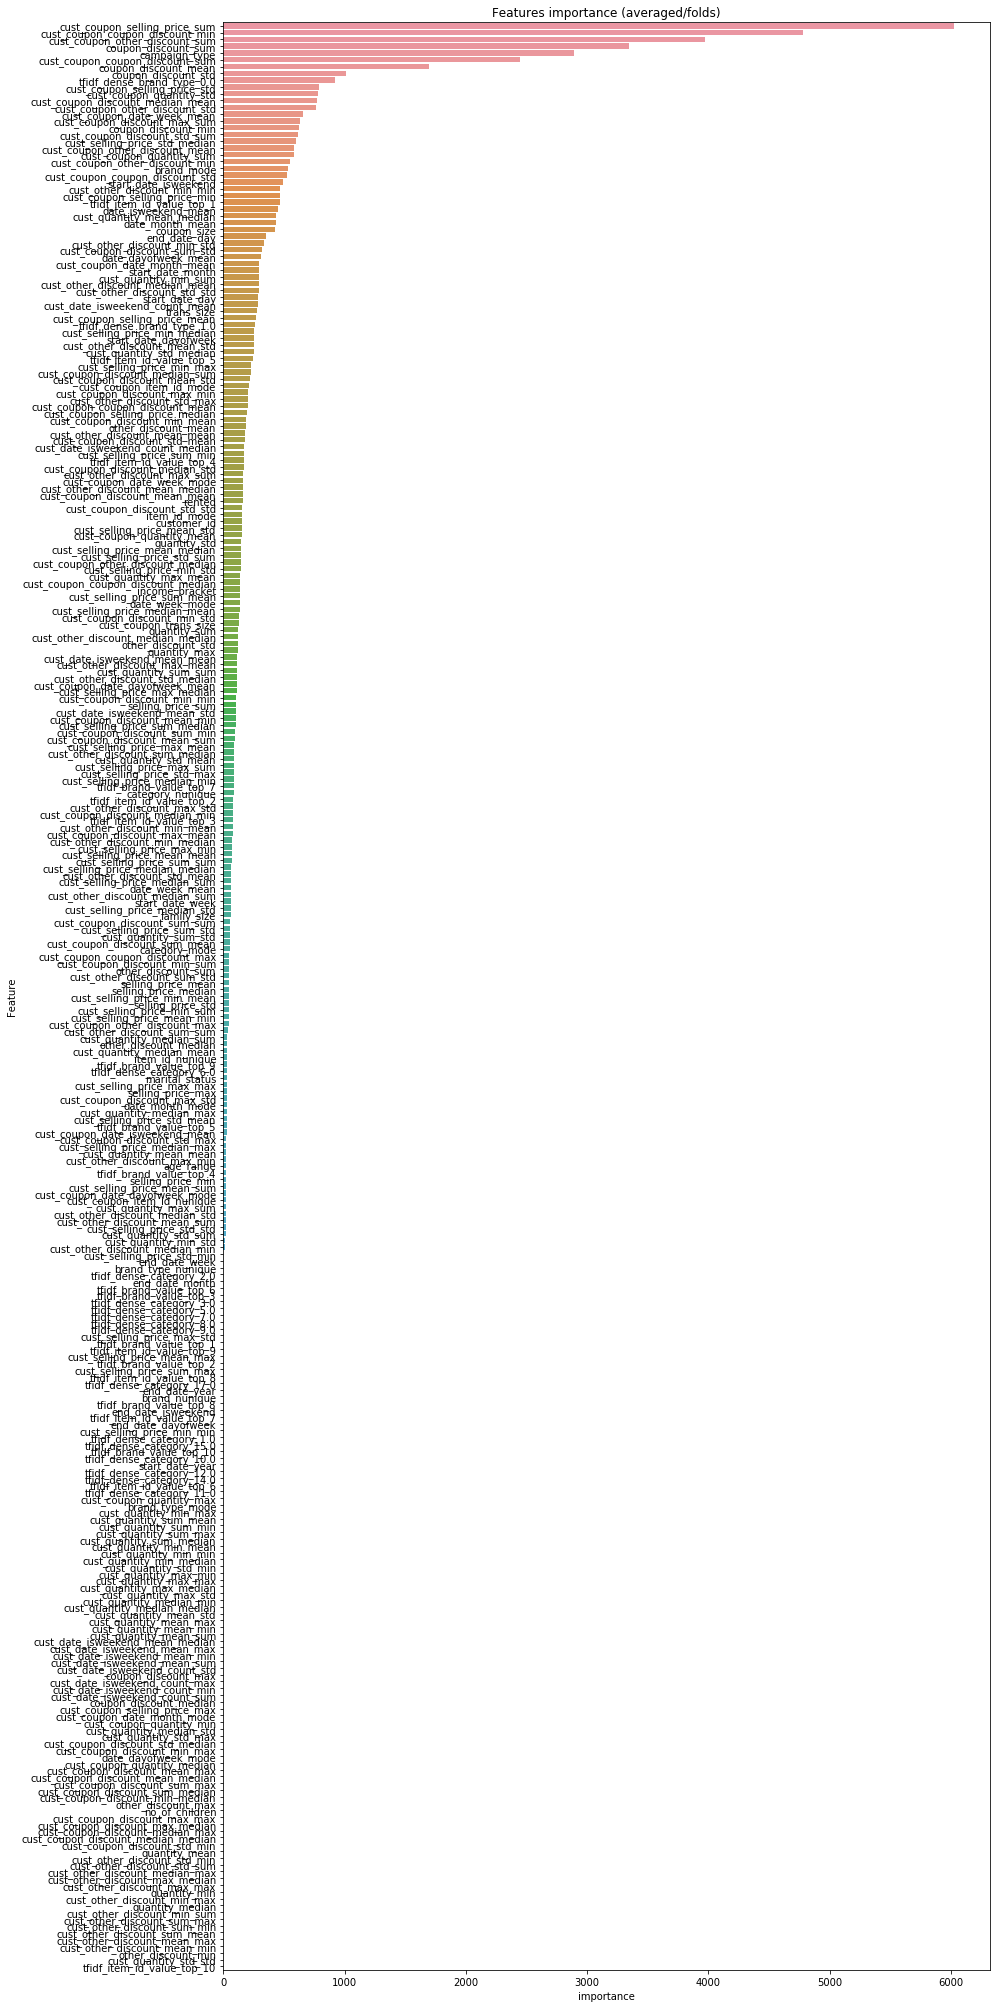

In [54]:
feature_importance_df_0= feature_importance_df[0]
cols = (feature_importance_df_0[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:300].index)
best_features = feature_importance_df_0.loc[feature_importance_df_0.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI-normal-0.png')

#### Test Predictions
##### Why different approach for test predictions ?
- Test Predictions are not generated from cross validation. The reason is that the model was not utilizing the complete set of customer_transaction_data. The cross validation was trained using merged data filtered upto start of validation and also each coupon and customer combination features in train is filtered for corresponding prior transactions (ie. before start of campaign date of each combination). 
- So, it is decided to utilize the full training set without validation set for test predictions and also get the merged data for training including all transactions (i.e no filter). 
##### How cross validation results are going to be used in full train model ?
- But, it does not mean that the earlier cross validation is not useful. The cross validation is very useful in determining the number of estimators for executing full train model.
- There are below possible iteration numbers are used from the 5 splits of time series CV
	- Average number of iterations 
	- Maximum number of iterations
	- Minimum number of iterations
- 3 different models using full train set is generated using above iterations as estimators for light gbm model and then all these 3 models are blended (ie ensembled) to generate final test predictions. 
- With this test predictions, the test score in public LB have improved 2 points from 0.91 to 0.93

In [55]:
#Date Validation split
import datetime


def runfulltrain(train_full_enc, test_enc,target,features,params,
                  fit_function_full,predict_function_full):

    feature_importance_df = pd.DataFrame()
    
    predictions = np.zeros(test.shape[0])
        
    clf = fit_function_full(train_full_enc[features],target,param)
    print('Fit complete')

    predictions += predict_function_full(clf,test_enc[features],param)
    print('Test Pred complete')

    if hasattr(clf, 'feature_importance'):
        feature_importance_df["Feature"] = features
        feature_importance_df["importance"] = clf.feature_importance()    
   
    return clf,predictions,feature_importance_df


In [56]:
iterations_arr = np.array(iterations)
iterations_arr

array([ 22, 542,  24,  47,   1])

#### Generate merging of full train data (i.e without any filter on valid date) 

In [57]:
def gen_full_train_encs(train,test_enc,targetcol,target,coupon_to_item):

    #merge trans summary feats
    train_full_enc=merge_trans_fold(train,coupon_to_item,None)
    print("Multilevel Customer with Trans")
    cust_multi_agg = merge_multilevel_bycustomer_onitem(None)
    train_full_enc = pd.merge(train_full_enc,cust_multi_agg,on='customer_id',how='left')
    
    #merge tfidf 
    texts=gen_amex_tfidf_fold(train_full_enc,top_n=10,val_min_start_date=None)
    train_full_enc = pd.merge(train_full_enc,texts, on=['customer_id','coupon_id'],how='left')
    train_full_enc =drop_missed_cols(train_full_enc , test_enc, targetcol)
    text_cols = [col for col in train_full_enc.columns if ('_texts') in col]
    train_full_enc = train_full_enc.drop(text_cols,axis=1)

    #         train_full_enc =gen_Feature_Interactions(train_full_enc)

    cur_features= getfeatures(train_full_enc)
    train_full_enc = train_full_enc[cur_features]
    train_full_enc[targetcol]=target.reset_index(drop=True)

    return train_full_enc, cur_features

In [58]:
%%time
#generate merge fold encodings
train_full_enc, train_full_features = gen_full_train_encs(train,test_encs[0],targetcol,target,coupon_to_item)

Multilevel Customer with Trans


11426it [00:01, 9650.02it/s]
11426it [00:01, 9313.29it/s]


Length of features of current fold: 287

List of features of current fold: ['customer_id', 'campaign_type', 'start_date_day', 'start_date_month', 'start_date_year', 'start_date_dayofweek', 'start_date_isweekend', 'start_date_week', 'end_date_day', 'end_date_month', 'end_date_year', 'end_date_dayofweek', 'end_date_isweekend', 'end_date_week', 'coupon_size', 'brand_nunique', 'brand_mode', 'brand_type_nunique', 'brand_type_mode', 'category_nunique', 'category_mode', 'age_range', 'marital_status', 'rented', 'family_size', 'no_of_children', 'income_bracket', 'trans_size', 'item_id_nunique', 'item_id_mode', 'date_isweekend_mean', 'date_month_mean', 'date_month_mode', 'date_week_mean', 'date_week_mode', 'date_dayofweek_mean', 'date_dayofweek_mode', 'quantity_mean', 'quantity_sum', 'quantity_min', 'quantity_max', 'quantity_median', 'quantity_std', 'other_discount_mean', 'other_discount_sum', 'other_discount_min', 'other_discount_max', 'other_discount_median', 'other_discount_std', 'coupon_disc

Perform Full Train Model and generate test predictions using mean number of iterations as number of estimators from Cross Validation model

In [59]:
%%time
#run full train with average no of iterations
cur_iterations = int(np.mean(iterations_arr))
param['n_estimators'] = cur_iterations
print('cur_iterations:',cur_iterations)
model_full_train,predictions_mean,feature_importance_df_full = \
runfulltrain(train_full_enc, test_encs[0],target,train_full_features,param,
                  lgb_fit_full,lgb_predict_full)

cur_iterations: 127


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Fit complete
Test Pred complete
CPU times: user 19.7 s, sys: 1.46 s, total: 21.1 s
Wall time: 6.7 s


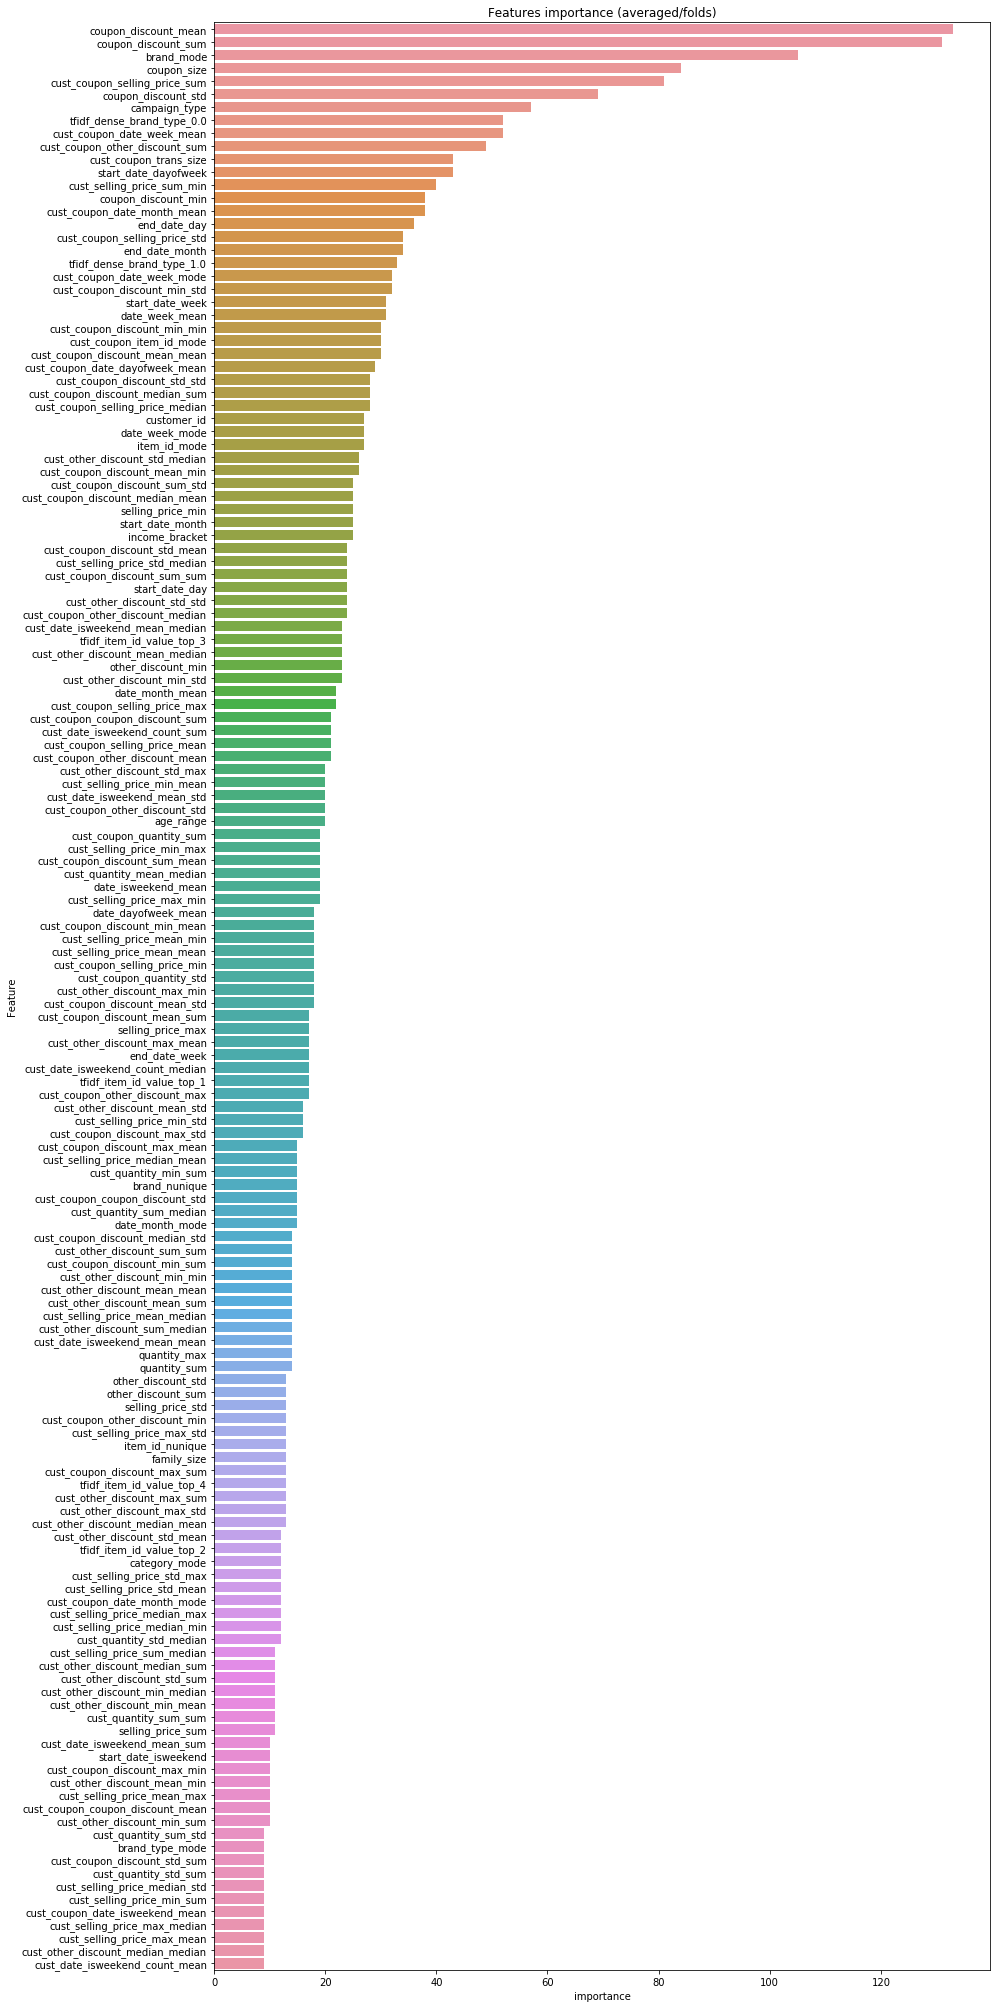

In [60]:
cols = (feature_importance_df_full[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df_full.loc[feature_importance_df_full.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI-fulltrain.png')

In [61]:
subm[targetcol] = predictions_mean
subm.to_csv('submission_fulltrain_mean.csv', index=False)
print(subm.head(10))

   id  redemption_status
0   3           0.285228
1   4           0.024122
2   5           0.018248
3   8           0.003134
4  10           0.003403
5  12           0.011072
6  13           0.005464
7  16           0.003134
8  18           0.007056
9  31           0.005476


Perform Full Train Model and generate test predictions using minimum number of iterations as number of estimators from Cross Validation model.
Since minimum number of iterations is just 1, to overcome underfitting, first fold iterations count is used for full train predictions with minimum number of iterations.

In [62]:
%%time
#run full train with first fold iterations
cur_iterations = int(iterations_arr[0])
param['n_estimators'] = cur_iterations
print('cur_iterations:',cur_iterations)
model_full_train,predictions_min,feature_importance_df_full = \
runfulltrain(train_full_enc, test_encs[0],target,train_full_features,param,
                  lgb_fit_full,lgb_predict_full)

cur_iterations: 22
Fit complete
Test Pred complete
CPU times: user 8.21 s, sys: 1.23 s, total: 9.44 s
Wall time: 3.68 s


In [63]:
subm[targetcol] = predictions_min
subm.to_csv('submission_fulltrain_min.csv', index=False)
print(subm.head(10))

   id  redemption_status
0   3           0.089709
1   4           0.014821
2   5           0.007939
3   8           0.007676
4  10           0.007676
5  12           0.010644
6  13           0.007881
7  16           0.007676
8  18           0.009035
9  31           0.007881


Perform Full Train Model and generate test predictions using maximum number of iterations as number of estimators from Cross Validation model.

In [64]:
%%time
#run full train with max no of iterations
cur_iterations = int(np.max(iterations_arr))
param['n_estimators'] = cur_iterations
print('cur_iterations:',cur_iterations)
model_full_train,predictions_max,feature_importance_df_full = \
runfulltrain(train_full_enc, test_encs[0],target,train_full_features,param,
                  lgb_fit_full,lgb_predict_full)

cur_iterations: 542
Fit complete
Test Pred complete
CPU times: user 1min 13s, sys: 2.14 s, total: 1min 15s
Wall time: 20.6 s


In [65]:
subm[targetcol] = predictions_max
subm.to_csv('submission_fulltrain_max.csv', index=False)
print(subm.head(10))

   id  redemption_status
0   3           0.344102
1   4           0.015471
2   5           0.059228
3   8           0.000184
4  10           0.000358
5  12           0.004910
6  13           0.002597
7  16           0.000227
8  18           0.007356
9  31           0.003121


3 different LightGBM models using full train set is generated using different number of estimators (using mean, max,min iterations of cross validation model)  for light gbm model and then all these 3 models are blended (ie ensembled) to generate final test predictions. 

In [66]:
#full train ens subm
predictions_full_train_iter_ens = (predictions_max + predictions_min + predictions_mean) / 3
subm[targetcol] = predictions_full_train_iter_ens
subm.to_csv('submission_fulltrain_ens.csv', index=False)
print(subm.head(10))

   id  redemption_status
0   3           0.239680
1   4           0.018138
2   5           0.028472
3   8           0.003665
4  10           0.003812
5  12           0.008875
6  13           0.005314
7  16           0.003679
8  18           0.007816
9  31           0.005493


The above csv file is used for submission into the competition

Save all merged encodings

In [67]:
#save fold level train, test and val
#Date Validation split
import datetime

def save_fold_encs(tr_encs,val_encs,test_encs,n_splits):
    
    tr_all = pd.DataFrame()
    val_all = pd.DataFrame()
    test_all = pd.DataFrame()
    for fold_ in range(n_splits):
        print('fold:',fold_)
        tr =tr_encs[fold_]
        val =val_encs[fold_]
        test_cur =test_encs[fold_]
        
        tr['fold'] = fold_; val['fold'] = fold_; test_cur['fold'] = fold_
        
        print('save individual fold data files')
        tr.to_csv('tr_'+str(fold_)+'.csv',index=False)
        val.to_csv('val_'+str(fold_)+'.csv',index=False)
        test_cur.to_csv('test_'+str(fold_)+'.csv',index=False)
   
        print('concat data ')
        tr_all = pd.concat([tr_all,tr],axis=0)
        val_all = pd.concat([val_all,val],axis=0)
        test_all = pd.concat([test_all,test_cur],axis=0)
        
#         print(tr_all.head())

    print('save all data files')
    tr_all.to_csv('tr_all.csv',index=False)
    val_all.to_csv('val_all.csv',index=False)
    test_all.to_csv('test_all.csv',index=False)
    
    return tr_all,val_all,test_all


In [68]:
#save normal encs
tr_all,val_all,test_all = save_fold_encs(tr_encs,val_encs,test_encs,n_splits)

fold: 0
save individual fold data files
concat data 
fold: 1
save individual fold data files
concat data 


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



fold: 2
save individual fold data files
concat data 
fold: 3
save individual fold data files
concat data 
fold: 4
save individual fold data files
concat data 
save all data files


In [69]:
#save full train encs
train_full_enc.to_csv('train_full_enc.csv',index=False)